In [1]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

import seaborn

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline

from scipy.stats import norm

import pandas as pd

from phase_transition_experiment.sample_survival_poisson import sample_survival_poisson
from twosample import binom_test

In [2]:
def quantile(x, q):
    """
    Compute the q-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .95)

def q95(x):
    return quantile(x, .95)

def q80(x):
    return quantile(x, .8)

from scipy.optimize import curve_fit

def fit_sigmoid(xdata, ydata):
    def sigmoid(x, intercept, slope):
        return 1 / (1+np.exp(-slope * (x - intercept)))

    popt, pcov = curve_fit(sigmoid, xdata, ydata, [.5, 1], method="lm")
    return popt

def sigmoid_intercept(xdata, binary_vector):
    """
    Return the intercept of a sigoid fitted to the binary vector
    """
    try:
        return fit_sigmoid(xdata, binary_vector)[0]
    except:
        return np.nan


def rhos(be, sigma=1):
    if sigma**2 < 2:
         ret = (2 - sigma**2) * (be - 1/2) * (be < 1 - sigma**2/4) + (1 - sigma*np.sqrt(1- be))**2 * (be >= 1 - sigma**2/4)
    else:
         ret = (1 - sigma*np.sqrt(1 - be))**2 * (be > 1 - 1/sigma**2)
    return np.maximum(ret, 0)


def compute_power_mat(df, tcrit):
    bb = df['beta'].unique()
    rr = df['r'].unique()
    
    mat = np.zeros((len(bb), len(rr)))
    for i,beta in enumerate(bb):
        for j,r in enumerate(rr):
            dfs = df[(df['beta'] == beta) & (dfc['r'] == r) ]
            empirical_power = np.mean(dfs['value'] > tcrit)
            mat[i,j] = empirical_power
    return mat


def compute_succ_mat(df, tcrit):
    bb = df['beta'].unique()
    rr = df['r'].unique()
    
    mat = np.zeros((len(bb), len(rr)))
    for i,beta in enumerate(bb):
        for j,r in enumerate(rr):
            dfs = df[(df['beta'] == beta) & (dfc['r'] == r) ]
            mat[i,j] = np.sum(dfs['value'] > tcrit)
    return mat


def compute_power(df, tcrit, level=0.05):
    """
    Empirical power of test statistics 'value' at level 'level'
    and binomial P-value of a test for power 
    significantly better than 'level' 
    """
    df_res = pd.DataFrame()
    for i,c in enumerate(df.groupby(['beta', 'r'])):
        nMonte = len(c[1])
        empirical_power = np.mean(c[1]['value'] > tcrit)
        binom_pval = binom_test(empirical_power * nMonte,
                                            np.array(nMonte), level, alt='greater')
        r = pd.DataFrame({'beta' : c[0][0],
                         'r' : c[0][1],
                         'empirical_power': empirical_power,
                         'empirical_power_pval': binom_pval}, index=[i]
                        )
        df_res = pd.concat([df_res, r])
    return df_res


### Read Results:

In [3]:
from glob import glob

#data_null = pd.read_csv("results/results_73046.csv").filter(regex = '^((?!Unnamed).)*$')
#data_null = pd.read_csv("./results_-3152.csv").filter(regex = '^((?!Unnamed).)*$')
#results = pd.read_csv("./results/results_32034.csv").filter(regex = '^((?!Unnamed).)*$')
#results = pd.read_csv("./results/merged.csv").filter(regex = '^((?!Unnamed).)*$')
#results = pd.read_csv("./test.csv").filter(regex = '^((?!Unnamed).)*$')
#results = pd.read_csv("./results/results_73046.csv").filter(regex = '^((?!Unnamed).)*$')

lo_files = glob(r"./results/results_*.csv")
#lo_files = glob(r"./phase_transition_experiment/results_-6847.csv")
print(lo_files)
results = pd.concat([pd.read_csv(fn).filter(regex = '^((?!Unnamed).)*$') for fn in lo_files])

out_filename = 'fig'
df0 = results[results.r == 0]
df1 = results

len(df1.beta.unique())


['./results/results_44935.csv', './results/results_61020.csv', './results/results_-1671.csv', './results/results_76688.csv', './results/results_84381.csv', './results/results_73046.csv', './results/results_14638.csv', './results/results_-8703.csv']


11

In [4]:
def get_nMonte(df1, stat_name):
    dft = df1[~df1[stat_name].isna()]
    nconf = len(dft.groupby(['r', 'beta', 'T', 'N1', 'N2', 'lam0']).count())
    nMonte = len(df1[stat_name].dropna()) / nconf
    assert nMonte.is_integer()
    return nMonte

### Critical test values

In [5]:
level = .05
global_params = ['T', 'N1', 'N2']
tcrit = df0.groupby(global_params).agg(lambda x : quantile(x, 1-level))
tcrit

,,,job_id,itr,lam0,beta,r,log_rank_greater,log_rank_pval_greater,hc_greater,fisher_greater,min_p_greater,...,fisher_less,min_p_less,berk_jones_less,logrank_lifelines_None,logrank_lifelines_wilcoxon,logrank_lifelines_tarone-ware,logrank_lifelines_peto,logrank_lifelines_fleming-harrington10,logrank_lifelines_fleming-harrington01,logrank_lifelines_fleming-harrington11
T,N1,N2,,,,,,,,,,,,,,,,,,,,,
1000,10000,10000,NaN,190.05,1.0,0.95,0.0,1.641109,0.947028,0.881786,1605.668193,8.313482,...,1606.159308,8.314285,46.051702,3.843869,3.887556,3.845086,3.888337,3.920049,3.796384,3.750636


Analyzing the case (T, N1, N2) = (1000, 10000, 10000)
nMonte =  1600.0


/Users/kipnisal/Dropbox/Research/survival/env/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


nMonte =  1600.0


/Users/kipnisal/Dropbox/Research/survival/env/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_65217/1468539181.py:20: RuntimeWarning: overflow encountered in exp
  return 1 / (1+np.exp(-slope * (x - intercept)))


nMonte =  1600.0


/Users/kipnisal/Dropbox/Research/survival/env/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


nMonte =  1600.0


/Users/kipnisal/Dropbox/Research/survival/env/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_65217/1468539181.py:20: RuntimeWarning: overflow encountered in exp
  return 1 / (1+np.exp(-slope * (x - intercept)))


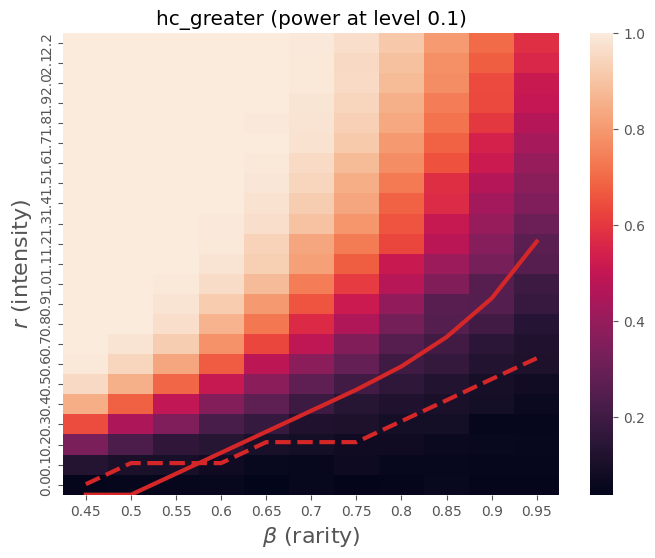

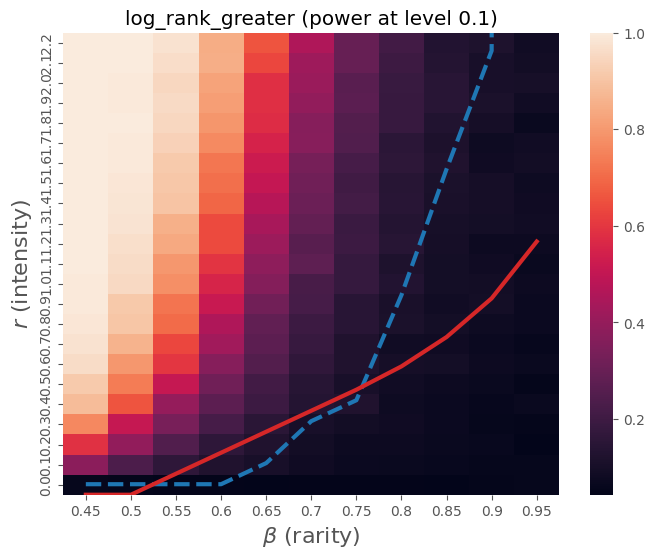

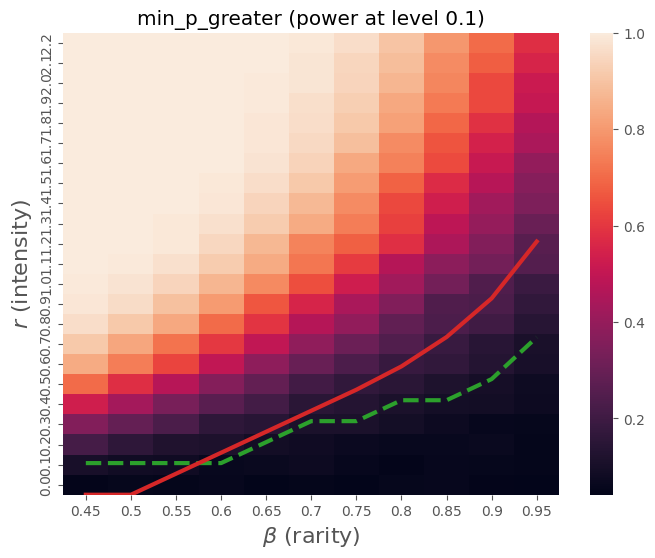

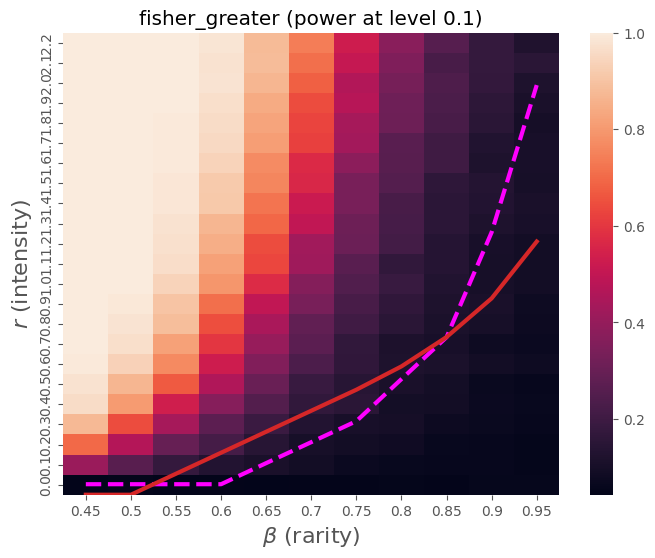

In [6]:
out_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/Figs/"
out_dir = "Figs/"
out_filename = out_dir + 'phase_diagram_'
#def illustrate_phase_diagrams(df1, df0, out_filename='phase_diagram'):
"""

Args:
-----
:df1:   results from experiments under alternative 
:df0:   results from experiments under null
:out_filename:   file/path name to write to
"""

params = ['itr', 'T', 'N1', 'N2', 'r', 'beta']
tests = [
 'hc_greater', 'log_rank_greater', 'min_p_greater', 'fisher_greater', 
  #'logrank_lifelines_None', 'logrank_lifelines_wilcoxon', 'logrank_lifelines_peto', 
  #'logrank_lifelines_fleming-harrington01', 'logrank_lifelines_fleming-harrington11'
  ]
#tests = ['hc_greater']
tests_vars = [c for c in df0.columns if c not in params and 'Unnamed' not in c]

global_params = ['T', 'N1', 'N2']
level = 0.1

level_bin = 0.05

r_max = 2.3
good_side = 'greater'
bad_side = 'less'


colors = {'hc_greater': 'tab:red',
 'log_rank_greater': 'tab:blue',
 'min_p_greater': 'tab:green',
'berk_jones_greater': '#d62728',
 'fisher_greater': 'magenta',
 'logrank_lifelines_None': '#1f77b4',
 'logrank_lifelines_wilcoxon': 'tab:green',
'logrank_lifelines_peto': 'tab:purple',
'logrank_lifelines_fleming-harrington10': 'tab:orange',
'logrank_lifelines_fleming-harrington01': 'tab:orange',
'logrank_lifelines_fleming-harrington11': 'tab:orange'
 }

for c in df1.groupby(global_params):
    print(f"Analyzing the case (T, N1, N2) = {c[0]}")
    dfc = c[1]
    for tsn in tests:
        # we check rate when both sides succedds. These are not good outcomes
        bb = dfc['beta'].unique()
        rr = dfc['r'].unique()
        if "greater" not in tsn:
            tcrit.loc[:,tsn] = df0.groupby(global_params).agg(lambda x : quantile(x, 1-2*level))[tsn]

        nMonte = get_nMonte(dfc, tsn)
        print("nMonte = ", nMonte)
        
        def r2grid(r):
            return len(rr) / (rr.max() - rr.min()) * (rr.max() - r)
        
        def b2grid(b):
            return len(bb) / (bb.max() - bb.min()) * (b - bb.min())
        
        
        rcrit = np.zeros_like(bb)
        bcrit = np.zeros_like(rr)
        
        mat_succ = compute_succ_mat(dfc.rename(columns={tsn : 'value'}), tcrit[tsn].values[0])
                   
        # for j,r in enumerate(rr):
        #     empirical_power = mat[:,j]
        #     binom_pvals = binom_test(empirical_power * nMonte,
        #                             np.array(nMonte), level, alt='greater')
        #     print(empirical_power * nMonte)
        #     substentiality_indicator_beta = binom_pvals < level_bin
        #     if np.sum(substentiality_indicator_beta) == 0:
        #         bc = bb[0]
        #     elif substentiality_indicator_beta[-1] == False:
        #         bc = bb[-1]
        #     else:
        #         bc = sigmoid_intercept(bb, substentiality_indicator_beta)
        #     bcrit[j] = np.minimum(np.maximum(bc, 0.2), 1)
            
        for i,beta in enumerate(bb):
            no_succ = mat_succ[i,:]
            binom_pvals = binom_test(no_succ,
                                    np.array(nMonte), level, alt='greater')
            substentiality_indicator_r = binom_pvals < level_bin
            if substentiality_indicator_r[-1] == False:
                rcrit[i] = 100
            elif np.sum(substentiality_indicator_r) == 0:
                rcrit[i] = 100
            else:
                rc = sigmoid_intercept(rr, substentiality_indicator_r)
                rcrit[i] = np.minimum(np.maximum(rc, 0), r_max)
            
        plt.figure(figsize=(8,6))
        mat_power = mat_succ / nMonte
        g = seaborn.heatmap(mat_power[:,::-1].T)
        plt.title(f"{tsn} (power at level {level})")
        g.set_xticklabels(bb)
        g.set_xlabel(r'$\beta$ (rarity)', fontsize=16)
        g.set_ylabel(r'$r$ (intensity)', fontsize=16)
        g.set_yticklabels(np.round(rr[::-1],2))
        
        color = colors[tsn]
        g.plot(np.arange(len(bb))+.5, r2grid(rcrit), f'--', color=color, linewidth=3, alpha = 1)
        #g.plot(b2grid(bcrit[::-1])+ .5, np.arange(len(rr)), '--b', linewidth=2, alpha = .9)        
        g.plot(np.arange(len(bb))+.5, r2grid(2*rhos(bb)), color='tab:red', linewidth=3, alpha=1)
        
        fn = out_filename + tsn + ".png"
        plt.savefig(fn)
        #plt.show()
        

In [7]:
def binomial_proportion_test(n1, N1, n2, N2):
    phat1 = n1 / N1
    phat2 = n2 / N2
    phat = (n1 + n2) / (N1 + N2)
    z = (phat1 - phat2) / np.sqrt(phat * (1 - phat) * (1/N1 + 1/N2))
    pval = 2 * norm.cdf(-np.abs(z))
    return {'z': z, 'pval': pval}

/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_65217/2192400363.py:5: RuntimeWarning: invalid value encountered in divide
  z = (phat1 - phat2) / np.sqrt(phat * (1 - phat) * (1/N1 + 1/N2))


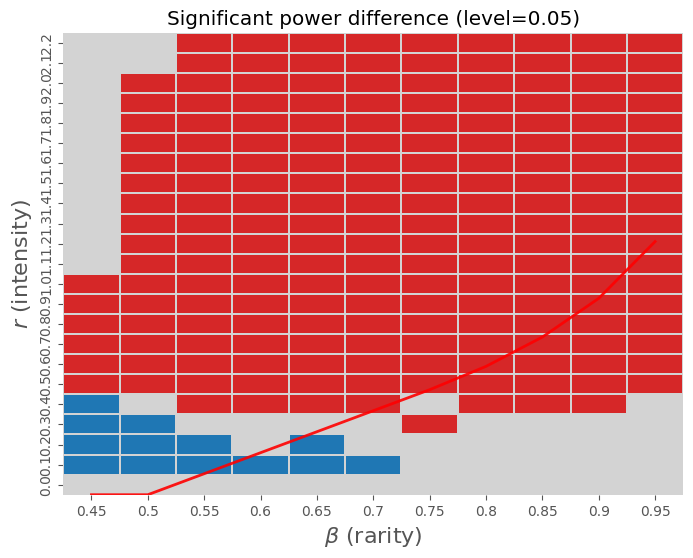

In [8]:
set_level_at_zero = True
from matplotlib.colors import LinearSegmentedColormap
myColors = (colors['logrank_lifelines_None'], 'lightgray', colors['hc_greater'])
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

dfp = df1#[df1.r == 0]

bb = dfp['beta'].unique()
rr = dfp['r'].unique()

alt_stat = 'log_rank_greater'
level = 0.05
mat_hc = compute_power_mat(dfp.rename(columns={'hc_greater' : 'value'}), tcrit['hc_greater'].values[0])
mat_alt = compute_power_mat(dfp.rename(columns={alt_stat : 'value'}), tcrit[alt_stat].values[0])

if set_level_at_zero:
    mat_hc[:,0] = level
    mat_alt[:,0] = level

nMonteHC = get_nMonte(dfp, 'hc_greater')
nMonteAlt = get_nMonte(dfp, alt_stat)

a = binomial_proportion_test(nMonteHC * mat_hc, nMonteHC, nMonteAlt * mat_alt, nMonteAlt)

mat_sig_hc = (a['pval'] < level) * (a['z'] > 0) + 0.0
mat_sig_alt = (a['pval'] < level) * (a['z'] < 0) + 0.0
mat = mat_sig_hc - mat_sig_alt

#cmap = sns.color_palette("deep", n)
g = seaborn.heatmap(mat[:,::-1].T, cmap=cmap, cbar=False, 
                    linewidths=.1, linecolor='lightgray')

g.set_xticklabels(bb)
g.set_xlabel(r'$\beta$ (rarity)', fontsize=16)
g.set_ylabel(r'$r$ (intensity)', fontsize=16)
g.set_yticklabels(np.round(rr[::-1],2))
g.plot(np.arange(len(bb))+.5, r2grid(2*rhos(bb)), 'r', linewidth=2, alpha=.9)
plt.title(f"Significant power difference (level={level})")

plt.savefig(out_dir + f"sig_power_diff_HC_{alt_stat}.png")

plt.show()


In [9]:
from analyze_gene_expression_results import NAME_NEAT, COLOR_LIST_STATS

COLOR_LIST_STATS = {'HCHG': 'tab:red',
                    'Log-rank': 'tab:blue',
                    'Fleming-Harrington01': 'tab:orange',
                    'Fleming-Harrington10': 'tab:orange',
                    'Fleming-Harrington11': 'tab:orange',
                    'Tarone-Ware': 'tab:purple',
                    'Peto-Peto': 'tab:brown',
                    'Gehan-Wilcoxon': 'tab:green',
                    'Others': 'tab:purple',
                    'MinP': 'tab:green'
                    }

NAME_NEAT = {'hc_greater': "HCHG",
             'log_rank_greater': 'Log-rank',
        'logrank_lifelines_fleming-harrington01': 'Fleming-Harrington01',
        'logrank_lifelines_fleming-harrington01_rev': 'Fleming-Harrington01',
        'logrank_lifelines_fleming-harrington11': 'Fleming-Harrington11',
        'logrank_lifelines_fleming-harrington11_rev': 'Fleming-Harrington11',
       #'logrank_lifelines_fleming-harrington10': 'Fleming-Harrington10',
       #'logrank_lifelines_fleming-harrington10_rev': 'Fleming-Harrington10',
       'logrank_lifelines_tarone-ware': 'Tarone-Ware',
       'logrank_lifelines_tarone-ware_rev': 'Tarone-Ware',
        'logrank_lifelines_peto': 'Peto-Peto',
        'logrank_lifelines_peto_rev': 'Peto-Peto',
        'logrank_lifelines_wilcoxon': 'Gehan-Wilcoxon',
        'logrank_lifelines_wilcoxon_rev': 'Gehan-Wilcoxon',
        'others': 'Others',
        'min_p_greater': 'MinP'
        }

INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /Library/Frameworks/R.framework/Resources
INFO:rpy2.situation:R library path: 
INFO:rpy2.situation:LD_LIBRARY_PATH: 
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
INFO:rpy2.rinterface_lib.embedded:R is already initialized. No need to initialize.


/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_65217/2325424413.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(df_diff['beta'], 2*rhos(df_diff['beta']), 'r', linewidth=2, alpha=.9, color="tab:red")


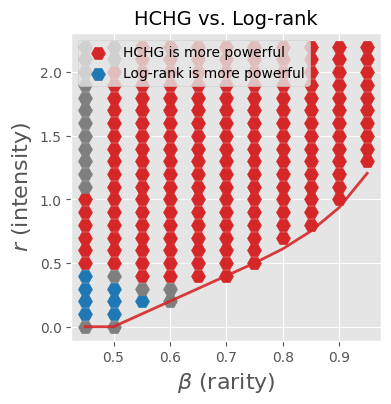

/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_65217/2325424413.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(df_diff['beta'], 2*rhos(df_diff['beta']), 'r', linewidth=2, alpha=.9, color="tab:red")


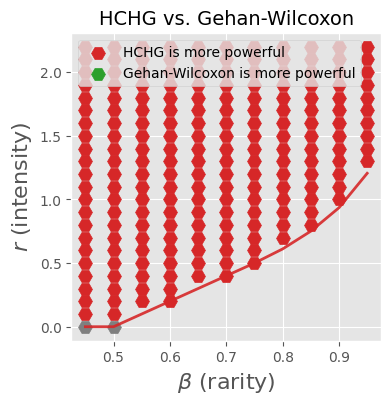

/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_65217/2325424413.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(df_diff['beta'], 2*rhos(df_diff['beta']), 'r', linewidth=2, alpha=.9, color="tab:red")


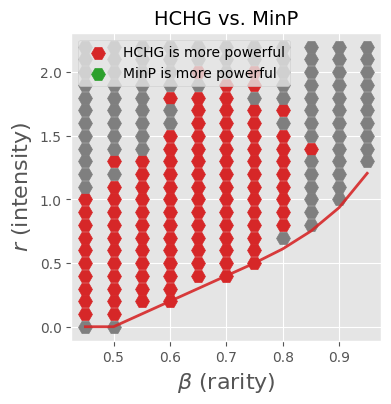

/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_65217/2325424413.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(df_diff['beta'], 2*rhos(df_diff['beta']), 'r', linewidth=2, alpha=.9, color="tab:red")


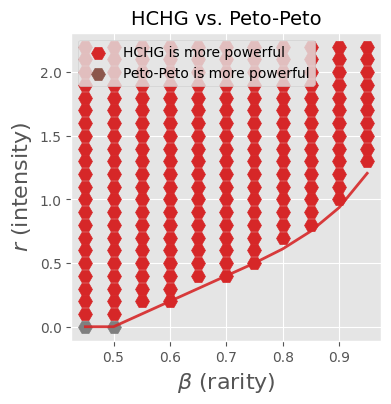

/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_65217/2325424413.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(df_diff['beta'], 2*rhos(df_diff['beta']), 'r', linewidth=2, alpha=.9, color="tab:red")


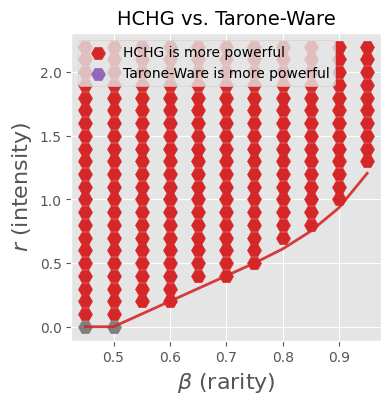

In [13]:

sig_level = 0.05
stats = ['log_rank_greater', 'logrank_lifelines_wilcoxon', 'min_p_greater',
          'logrank_lifelines_peto', 'logrank_lifelines_tarone-ware']

#stats = ['log_rank_greater']

for stat in stats:
    alt_name = stat
    alt_neat_name = NAME_NEAT[stat]
    alt_color = COLOR_LIST_STATS[alt_neat_name]
    null_color = "tab:gray"

    Nalt = get_nMonte(df1, alt_name)
    Nhc = get_nMonte(df1, 'hc_greater')


    df_alt = compute_power(df1.rename(columns={alt_name : 'value'}), tcrit[alt_name].values[0])
    df_hc = compute_power(df1.rename(columns={'hc_greater' : 'value'}), tcrit['hc_greater'].values[0])

    df_diff = df_hc.merge(df_alt, on=['beta', 'r'], suffixes=('_hc', '_alt'))

    df_diff.loc[(df_diff['r'] == 0.1) & (df_diff['beta'] == 0.65), 'empirical_power_alt'] = 0.05
    df_diff.loc[(df_diff['r'] == 0.1) & (df_diff['beta'] == 0.7), 'empirical_power_alt'] = 0.05

    a_hc = binomial_proportion_test(Nhc * df_diff['empirical_power_hc'], Nhc, Nhc * sig_level, Nhc)
    a_alt = binomial_proportion_test(Nalt * df_diff['empirical_power_alt'], Nalt, Nalt * sig_level, Nalt)

    a = binomial_proportion_test(Nhc * df_diff['empirical_power_hc'], Nhc,
                                  Nalt * df_diff['empirical_power_alt'], Nalt)
    

    na_idcs = np.isnan(a['pval'])
    a['pval'][na_idcs] = 1
    df_diff.loc[:, 'sig_hc'] = (a_hc['pval'] < sig_level) * (a_hc['z']>0) * (a['pval'] < sig_level) * (a['z'] > 0) + 0.0
    df_diff.loc[:, 'sig_alt'] = (a_alt['pval'] < sig_level) * (a_hc['z']>0) * (a['pval'] < sig_level) * (a['z'] < 0) + 0.0

    plt.figure(figsize=(4,4))

    idcs_relevant = df_diff['r'] >= 2*rhos(df_diff['beta']) 
    idcs_HC = (a['pval'] < sig_level) * (a['z'] > 0) * idcs_relevant
    idcs_alt = (a['pval'] < sig_level) * (a['z'] < 0) * idcs_relevant
    idcs_null = (a['pval'] > sig_level) * idcs_relevant


    
    plt.scatter(df_diff.loc[idcs_HC, 'beta'], df_diff.loc[idcs_HC, 'r'], c="tab:red", s=100, marker='H')
    plt.scatter(df_diff.loc[idcs_alt, 'beta'], df_diff.loc[idcs_alt, 'r'], c=alt_color, s=100, marker='H')
    plt.scatter(df_diff.loc[idcs_null, 'beta'], df_diff.loc[idcs_null, 'r'], c=null_color, s=100, marker='H')
    plt.legend(['HCHG is more powerful', f'{alt_neat_name} is more powerful'], loc='upper left')
    
    plt.plot(df_diff['beta'], 2*rhos(df_diff['beta']), 'r', linewidth=2, alpha=.9, color="tab:red")
    plt.xlabel(r'$\beta$ (rarity)', fontsize=16)
    plt.ylabel(r'$r$ (intensity)', fontsize=16)
    plt.title(f"HCHG vs. {alt_neat_name}", fontsize=14)
    plt.savefig(out_dir + f"sig_power_diff_HC_{alt_neat_name}.png", bbox_inches='tight', dpi=180, pad_inches=0)
    #plt.yticklabels(np.round(rr[::-1],2))
    #plt.xticklabels(bb)
    plt.show()

## Fisher seems to significantly outperform log-rank

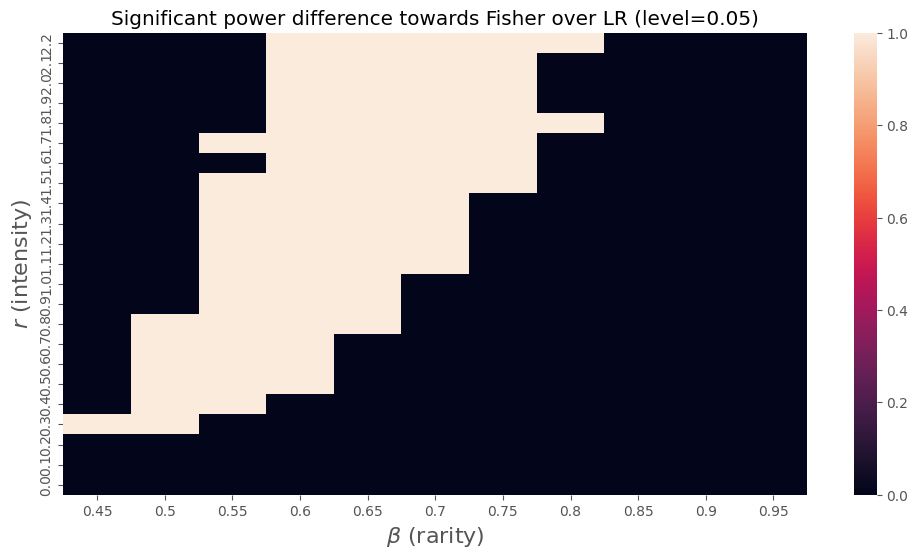

In [85]:
mat2 = compute_power_mat(df1.rename(columns={'log_rank_greater' : 'value'}), tcrit['log_rank_greater'].values[0])
mat1 = compute_power_mat(df1.rename(columns={'fisher_greater' : 'value'}), tcrit['fisher_greater'].values[0])

dmat = (mat1 - mat2)

mat_sig1 = dmat * np.sqrt(nMonte) > 2
mat_sig2 = dmat * np.sqrt(nMonte) < -2

g = seaborn.heatmap(mat_sig1[:,::-1].T)

g.set_xticklabels(bb)
g.set_xlabel(r'$\beta$ (rarity)', fontsize=16)
g.set_ylabel(r'$r$ (intensity)', fontsize=16)
g.set_yticklabels(np.round(rr[::-1],2))
plt.title(f"Significant power difference towards Fisher over LR (level={level})")
plt.savefig(out_dir + "sig_power_diff_fisher_LR.png")
plt.show()




## Check phase transition curves
For verifying theoretic result and comparing balanced vs. non-balanced

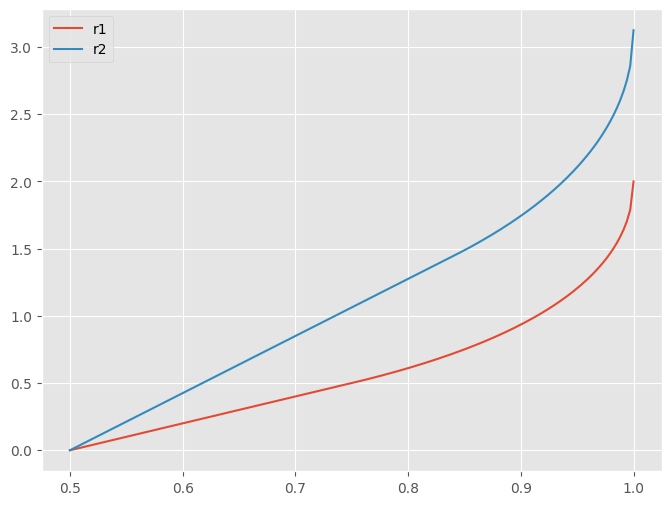

In [8]:
bb = np.linspace(0.5, 1, 171)

def rhos(be, sigma):
    if sigma**2 < 2:
        if be < 1 - sigma**2/4:
            return (2-sigma**2) * (be - 1/2)
        else:
            return (1-sigma*np.sqrt(1- be))**2
    else:
        if be < 1 - 1/sigma**2:
            return 0
        else:
            return (1-sigma*np.sqrt(1- be))**2

        
def plot_PT(r, sig):
    bb = np.linspace(0.5, 1, 171)
    rr = [rhos(b, sig) / r for b in bb]
    plt.plot(bb, rr)

            
kappa = 1/5

kappa_bar = 1 - kappa

r1 = 1 / 2
sig1 = 1

plot_PT(r1, sig1)

r2 = 2 * kappa * kappa_bar
sig2 = np.sqrt(4 * kappa * kappa_bar)

plot_PT(r2, sig2)

plt.legend(['r1', 'r2'])
plt.show()

## Evaluate 

In [17]:
from survival import evaluate_rare_and_weak, _evaluate_test_stats, logrank_lifeline_survival_table, evaluate_test_stats_lifeline

In [18]:

def evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, **kwargs):
    """
    Evaluate many tests for comparing the lists Nt1 and Nt2

    Args:
    :Nt1: first list of at_risk subjects
    :Nt2: second list of at_risk subjects
    :Ot1: number of events in group 1
    :Ot2: number of events in group 2


    Compute several statistics of the two-sample data:
    log-rank
    higher criticism
    Fisher combination test
    minimum P-value
    Berk-Jones
    """

    randomize = kwargs.get('randomize', False)
    alternative = kwargs.get('alternative', 'both')  # 'both' != 'two-sided'
    stbl = kwargs.get('stbl', True)
    discard_ones = kwargs.get('discard_ones', True)  # ignore P-values that are one


    if alternative == 'both':
        r_greater = _evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, alternative='greater',
                                         stbl=stbl, randomize=randomize, 
                                         discard_ones=discard_ones)
        r_less = _evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, alternative='less',
                                      stbl=stbl, randomize=randomize,
                                        discard_ones=discard_ones)

        res = dict([(k + '_greater', r_greater[k]) for k in r_greater.keys()]
                    + [(k + '_less', r_less[k]) for k in r_less.keys()]
                    )
    else:
        r = _evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, alternative=alternative,
                                 stbl=stbl, randomize=randomize, discard_ones=discard_ones)
        res = dict([(k + '_' + alternative, r[k]) for k in r.keys()])


    Nt1 = np.concatenate([Nt1, [Nt1[-1]-Ot1[-1]]], axis=0)
    Nt2 = np.concatenate([Nt2, [Nt2[-1]-Ot2[-1]]], axis=0)
    Ct1 = (-np.diff(Nt1) - Ot1).astype(int)
    Ct2 = (-np.diff(Nt2) - Ot2).astype(int)

    assert np.abs(Ct1).sum() == 0
    assert np.abs(Ct2).sum() == 0


    res_ll = evaluate_test_stats_lifeline(Ot1, Ot2, Ct1, Ct2)

    return {**res, **res_ll}

In [27]:
STBL = True
T = 1000
N2 = N1 = 1000
lam0 = 1
beta = .75
r = 2

eps = T ** (-beta)
lam = lam0 * np.ones(T) / T

Nt1, Nt2 = sample_survival_poisson(T, N1, N2, lam, eps, r)
Ot1 = -np.diff(Nt1).astype(int)
Ot2 = -np.diff(Nt2).astype(int)
res = evaluate_test_stats(Nt1[:-1], Nt2[:-1], Ot1, Ot2,
                            randomized=True, alternative='both', stbl=STBL)
res

{'log_rank_greater': 3.4971245113362692,
 'log_rank_pval_greater': 0.00023515113472694074,
 'hc_greater': 2.1083571584896266,
 'fisher_greater': 759.939895583566,
 'min_p_greater': 14.767364532060938,
 'berk_jones_greater': 46.051701859880914,
 'log_rank_less': 3.4971245113362692,
 'log_rank_pval_less': 0.9997648488652731,
 'hc_less': -9.033794448555456,
 'fisher_less': 571.1598094908609,
 'min_p_less': 2.705683603188436,
 'berk_jones_less': 46.051701859880914,
 'logrank_lifelines_None': 6.681430282745484e-05,
 'logrank_lifelines_wilcoxon': 0.18792091465259764,
 'logrank_lifelines_tarone-ware': 0.043633758032626695,
 'logrank_lifelines_peto': 0.1632267628026677,
 'logrank_lifelines_fleming-harrington10': 0.16358736451730813,
 'logrank_lifelines_fleming-harrington01': 0.15633700117055566}